In [61]:
import os
import random
import gc
import math
import pydicom as dicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn   
from torch.nn import Conv2d
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm
from einops import repeat

import os
import glob
import random
import time
import json
import gc
import math
import collections
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation, rc

import pydicom as dicom
from pydicom.pixels import apply_voi_lut

from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import Conv2d
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.models as models
from torchvision import transforms
from torchvision.ops import Conv2dNormActivation

from tqdm import tqdm
from einops import repeat
from fontTools.otlLib.builder import LOOKUP_FLAG_USE_MARK_FILTERING_SET


In [ ]:
train_path = 'rsna_data/'
train_data = pd.read_csv(f'{train_path}/final_merged_df_expanded.csv')
test_data = pd.read_csv(f'{train_path}/expanded_test_desc.csv')

print(f"\ntrain data shape: {train_data.shape}")
print(', '.join(train_data.columns))
print(f"\ntest data shape: {test_data.shape}")
print(', '.join(train_data.columns.intersection(test_data.columns)))


train data shape: (247372, 11)
study_id, condition, level, severity, series_id, instance_number, x, y, series_description, row_id, image_path

test data shape: (169, 6)
study_id, condition, series_id, series_description, row_id, image_path


## Plots without coordinates

In [4]:
# MinMax scaling
def load_dicom(path):
    ds = dicom.dcmread(path)
    img = ds.pixel_array
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    img = (img * 255).astype(np.uint8)
    return img

[207875, 22787, 121681, 36069]


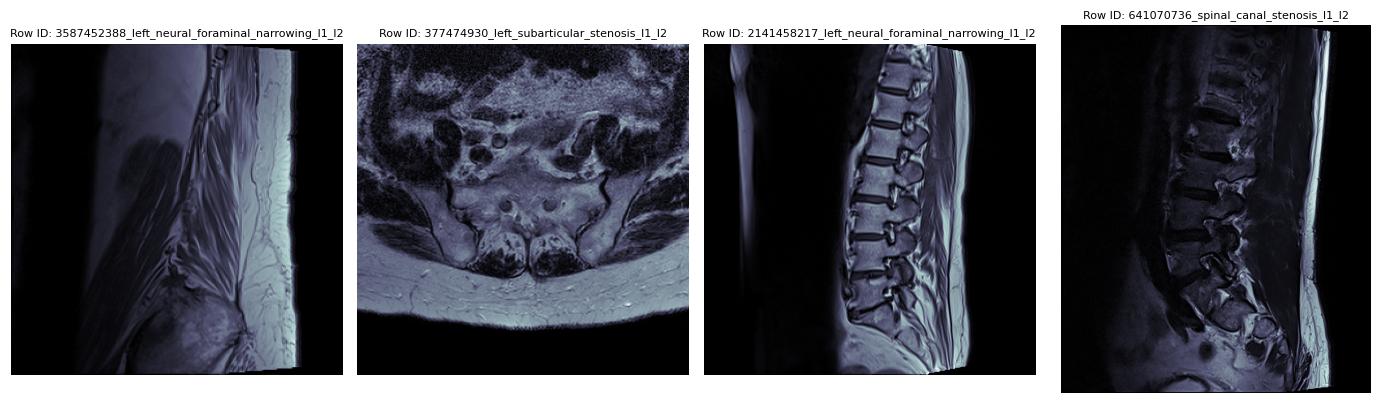

In [5]:
# Plot images
fig, ax = plt.subplots(1, 4, figsize=(14, 4))
selected_indices = random.sample(range(train_data.shape[0]), 4)
print(selected_indices)
for c, i in enumerate(selected_indices):
    ax[c].imshow(load_dicom(train_data['image_path'][i]), cmap=plt.cm.bone)
    ax[c].set_title(f'Row ID: {train_data["row_id"][i]}', fontsize=8)
    ax[c].axis('off')
plt.tight_layout()
plt.show()


## Managing Data for the Training Pipeline
### Making Custom Dataset Class

In [6]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.level_map = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1': 4}
        self.severity_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)
        if self.transform:
            image = self.transform(image)

        level = self.dataframe['level'][index]
        severity = self.dataframe['severity'][index]
        label = np.zeros(5, dtype=int)
        label[self.level_map[level]] = self.severity_map[severity]

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=32):

    filtered_df = df[df['series_description'] == series_description]

    train_df, val_df = train_test_split(filtered_df, test_size=0.18, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)), # still not sure if I should keep this
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

Visualizing Sagittal T1 samples


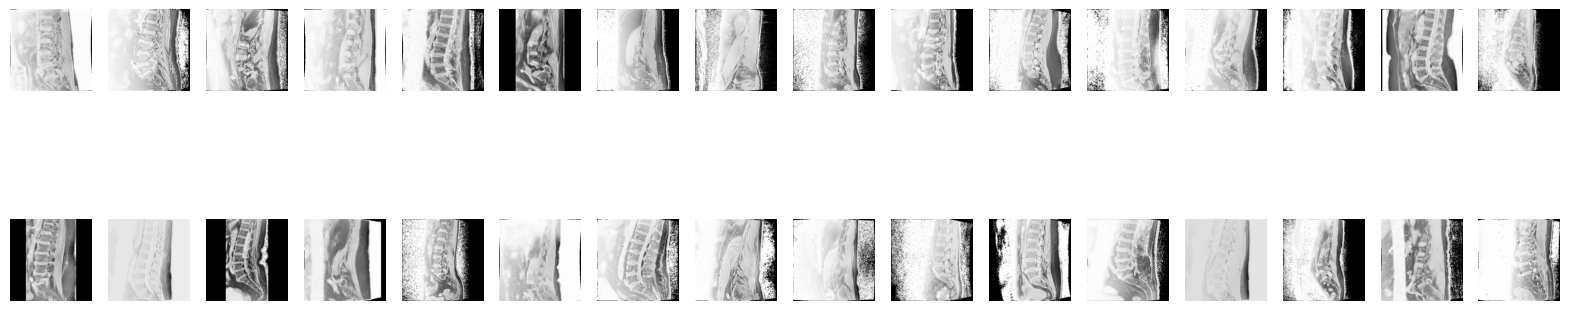

Visualizing Axial T2 samples


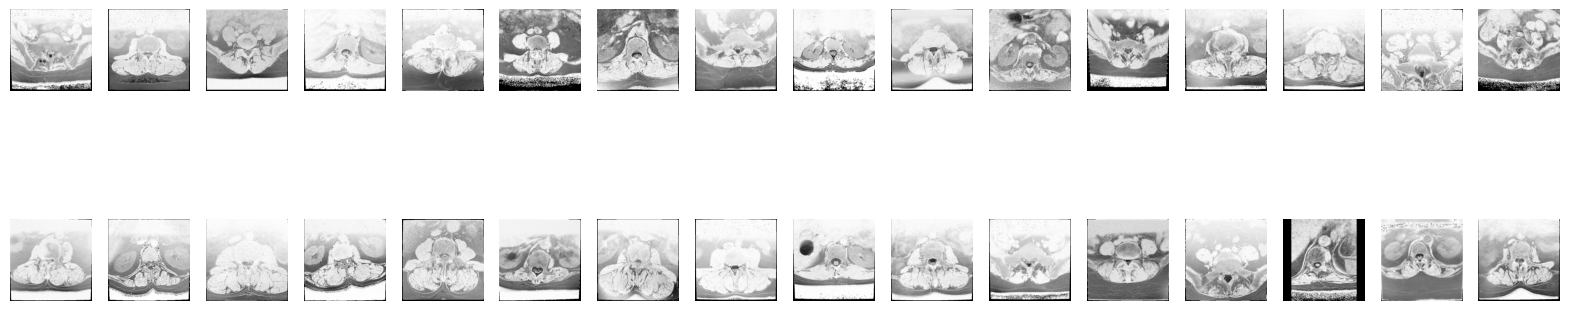

Visualizing Sagittal T2/STIR samples


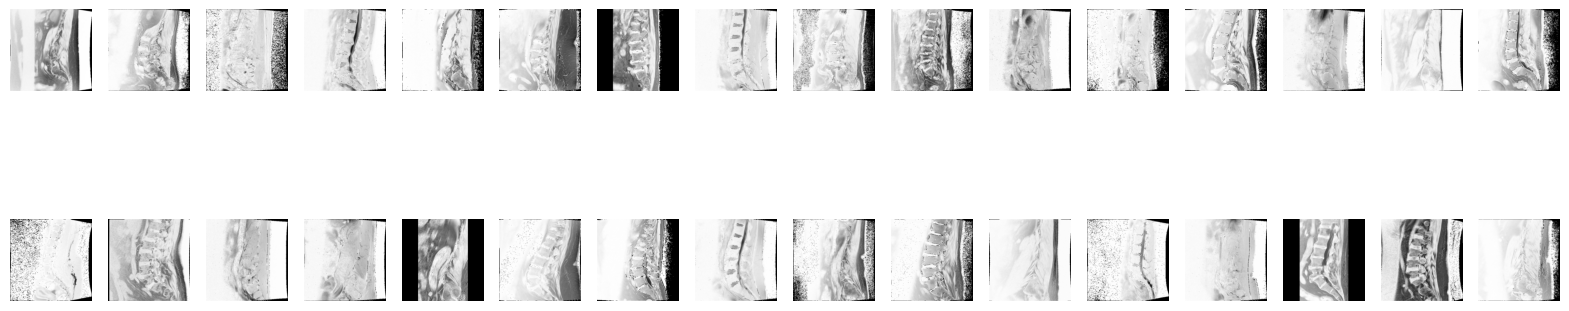

In [8]:
# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    n = len(images)//2
    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i//n][i%n]
        img = img.permute(1, 2, 0)
        ax.imshow(img)
        # ax.set_title(f"{lbl}")
        ax.axis('off')
    plt.show()

# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples")
visualize_batch(trainloader_t2stir)

# EfficientNetV2

### A pretrained image classification model was used as transfer learning model. The classification layer was replaced based on our current requirements.
### Additionally, the second to last classification layer was unfrozen and fine tuned for this domain.

In [9]:
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3,pretrained_weights=None):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)
        self.num_classes = num_classes
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights, weights_only=True))

        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes * 5)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 5, self.num_classes)
        return x

    def unfreeze_model(self, num_unfreeze=2):
        for layer in list(self.model.features.children())[-num_unfreeze:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True

        for param in self.model.classifier.parameters():
            param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# trainy_path =

weights_path = train_path + 'EfficientNet_v2.pth'

sagittal_t1_model = CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device)
axial_t2_model = CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device)
sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

num_f_layers = len(list(sagittal_t1_model.model.features.children()))
print(f"The number of layers in self.model.features: {num_f_layers}")

num_f_layers = len(list(sagittal_t1_model.model.classifier.children()))
print(f"The number of layers in self.model.features: {num_f_layers}")

cpu
The number of layers in self.model.features: 8
The number of layers in self.model.features: 2


In [10]:
for param in sagittal_t1_model.model.features.parameters():
    param.requires_grad = False
for param in axial_t2_model.model.features.parameters():
    param.requires_grad = False
for param in sagittal_t2stir_model.model.features.parameters():
    param.requires_grad = False

axial_t2_model.unfreeze_model(num_unfreeze=1)
sagittal_t2stir_model.unfreeze_model(num_unfreeze=1)

for param in sagittal_t1_model.model.classifier.parameters():
    param.requires_grad = True
for param in axial_t2_model.model.classifier.parameters():
    param.requires_grad = True
for param in sagittal_t2stir_model.model.classifier.parameters():
    param.requires_grad = True

def weighted_loss_function(outputs, labels, num_classes):
    if num_classes == 3:
        weights = torch.tensor([1.0, 2.5, 5.0]).to(device)
    else:
        weights = torch.tensor([1.0, 2.5, 5.0, 1.0, 2.5, 5.0]).to(device)
    loss = 0
    for i in range(5):
        loss_fn = nn.CrossEntropyLoss(weight=weights)
        loss += loss_fn(outputs[:, i, :], labels[:, i])
    return loss

optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.model.classifier.parameters(), lr=0.005)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.model.classifier.parameters(), lr=0.005)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.model.classifier.parameters(), lr=0.005)

custom_models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

In [11]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 38430


In [12]:
def print_pytorch_model_summary(model, input_size=(3, 224, 224)):
    print(f"{'Layer Name':<30} {'Output Shape':<30} {'Param #':<15} {'Type':<15}")
    print("="*100)

    # Create a dummy input tensor with the specified input size
    dummy_input = torch.rand(1, *input_size).to(next(model.parameters()).device)

    # Forward pass through the model to get output shapes
    def register_hook(module, module_type):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            # Module name and output shape
            m_key = f"{class_name}-{module_idx + 1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters()),
                "type": module_type
            }

        if (
            not isinstance(module, nn.Sequential) and
            not isinstance(module, nn.ModuleList) and
            module != model
        ):
            hooks.append(module.register_forward_hook(hook))

    # Register hooks for features and classifier separately
    summary = {}
    hooks = []

    # Register hooks for feature extraction layers
    model.model.features.apply(lambda module: register_hook(module, "Feature Extraction"))

    # Register hooks for classifier layers
    model.model.classifier.apply(lambda module: register_hook(module, "Classifier"))

    # Perform a forward pass to collect output shapes
    model(dummy_input)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    total_params = 0
    for layer in summary:
        # Layer name
        print(f"{layer:<30} {str(summary[layer]['output_shape']):<30} {summary[layer]['nb_params']:<15} {summary[layer]['type']:<15}")
        total_params += summary[layer]["nb_params"]

    print("="*100)
    print(f"Total Params: {total_params}")

def count_layers(module):
    num_layers = 0
    for child in module.children():
        if isinstance(child, nn.Sequential):
            num_layers += count_layers(child)
        else:
            num_layers += 1
    return num_layers

num_f_layers = count_layers(sagittal_t1_model.model.features)
print(f"The number of layers in self.model.features: {num_f_layers}")

num_c_layers = count_layers(sagittal_t1_model.model.classifier)
print(f"The number of layers in self.model.classifier: {num_c_layers}")

The number of layers in self.model.features: 46
The number of layers in self.model.classifier: 2


# Training
## the EfficientNetv2 Model

In [13]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=20, patience=3):
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0

        with tqdm(trainloader, unit="batch") as tepoch:
            for idx, (images, labels) in enumerate(tepoch):
                if idx == 2:
                    print("Timeout: after 2 batches\n")
                    return
                images, labels = images.to(device), labels.clone().detach().to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = weighted_loss_function(outputs, labels, model.num_classes)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()


                for i in range(5):
                    probabilities = torch.softmax(outputs[:, i, :], dim=1)
                    _, predicted = torch.max(probabilities, 1)
                    correct_train += (predicted == labels[:, i]).sum().item()

                tepoch.set_postfix(epoch=epoch+1)

        scheduler.step()


        train_loss /= len(trainloader)
        train_acc = 100*(correct_train/len_train)/5

        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.clone().detach().to(device)
                    outputs = model(images)
                    loss = weighted_loss_function(outputs, labels, model.num_classes)
                    val_loss += loss.item()

                    for i in range(5):
                        probabilities = torch.softmax(outputs[:, i, :], dim=1)
                        _, predicted = torch.max(probabilities, 1)
                        correct_val += (predicted == labels[:, i]).sum().item()

                    vepoch.set_postfix(epoch=epoch+1)


        val_loss /= len(valloader)
        val_acc = 100*(correct_val/len_val)/5


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1


        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break


    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [ ]:
# Training all models
for desc, model in custom_models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

    # run_with_timeout(train_model, (model, trainloader, valloader, len_train, len_val, optimizers[desc]), timeout=10)

Training model for Sagittal T1


  0%|          | 2/1717 [00:06<1:35:18,  3.33s/batch, epoch=1]


Timeout: after 2 batches

Training model for Axial T2


  0%|          | 2/3763 [00:06<3:19:42,  3.19s/batch, epoch=1]


Timeout: after 2 batches

Training model for Sagittal T2/STIR


  0%|          | 2/860 [00:06<46:03,  3.22s/batch, epoch=1]

Timeout: after 2 batches



# Mamba Model (2D)

In [33]:
class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""
    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)
        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)
        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """
        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)
        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""
        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))
            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

class S4D2D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, **kernel_args):
        super().__init__()
        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.D = nn.Parameter(torch.randn(self.h))
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout2d(dropout) if dropout > 0.0 else nn.Identity()
        self.output_linear = nn.Conv2d(self.h, self.h, kernel_size=1)

    def forward(self, u):
        # u shape: (B, H, H, W)
        B, C, H, W = u.shape
        u = u.reshape(B, C, H * W)

        L = H * W
        k = self.kernel(L=L)  # (H, L)
        k_f = torch.fft.rfft(k, n=2*L)  # (H, L)
        u_f = torch.fft.rfft(u, n=2*L)  # (B, H, L)
        y = torch.fft.irfft(u_f * k_f, n=2*L)[..., :L]  # (B, H, L)
        y = y + u * self.D.unsqueeze(-1)

        y = y.reshape(B, C, H, W)
        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        return y

class S4DImageProcessor2D(nn.Module):
    def __init__(self, in_channels, hidden_channels, d_state=64, s4_dropout=0.0):
        super().__init__()
        self.s4 = S4D2D(d_model=hidden_channels, d_state=d_state, dropout=s4_dropout)
        self.input_proj = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.output_proj = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.input_proj(x)
        x = self.s4(x)
        x = self.output_proj(x)
        return x

class EnsembleConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, dilation=2, n_conv_layers=3, d_state=64, s4_dropout=0.0):
        super().__init__()
        conv_3_list = []
        conv_5_list = []
        conv_7_list = []

        temp_in_channels = in_channels
        for _ in range(n_conv_layers):
            # convolution 3
            conv_3_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=3, padding=1))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, dilation=dilation, padding=(dilation * (3 - 1)) // 2))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, dilation=dilation, padding=(dilation * (3 - 1)) // 2))
            conv_3_list.append(nn.LeakyReLU(0.2))


            # convolution 5
            conv_5_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=5, padding=2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, padding=2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, dilation=dilation, padding=(dilation * (5 - 1)) // 2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, dilation=dilation, padding=(dilation * (5 - 1)) // 2))
            conv_5_list.append(nn.LeakyReLU(0.2))

            # convolution 7
            conv_7_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=7, padding=3))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, dilation=dilation, padding=(dilation * (7 - 1)) // 2))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, dilation=dilation, padding=(dilation * (7 - 1)) // 2))
            conv_7_list.append(nn.LeakyReLU(0.2))

            temp_in_channels = hidden_channels

        self.conv3 = nn.Sequential(*conv_3_list)
        self.conv5 = nn.Sequential(*conv_5_list)
        self.conv7 = nn.Sequential(*conv_7_list)

        self.s4d = S4DImageProcessor2D(hidden_channels * 3, hidden_channels * 3, d_state=d_state, s4_dropout=s4_dropout)

        self.final_conv = nn.Conv2d(hidden_channels * 3, in_channels, kernel_size=3, padding=1)
        self.final_act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x_copy = x.clone()
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)

        x = torch.cat([x3, x5, x7], dim=1)
        x = self.s4d(x)
        x = self.final_act(self.final_conv(x))

        x = x + x_copy
        return x

In [35]:
class LumbarClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, size=256,  n_conv_layers=2, d_state=64, s4_dropout=0.0):
        super().__init__()
        self.first_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.first_act = nn.LeakyReLU(0.2)

        # First Block
        self.s4_11 = EnsembleConv(hidden_channels, hidden_channels, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_12 = EnsembleConv(hidden_channels, hidden_channels, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_1 = nn.Conv2d(hidden_channels, hidden_channels * 2, stride=2, kernel_size=3, padding=1)

        # Second Block
        self.s4_21 = EnsembleConv(hidden_channels * 2, hidden_channels * 2, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_22 = EnsembleConv(hidden_channels * 2, hidden_channels * 2, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_2 = nn.Conv2d(hidden_channels * 2, hidden_channels * 4, stride=2, kernel_size=3, padding=1)

        # Third Block
        self.s4_31 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_32 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_3 = nn.Conv2d(hidden_channels * 4, hidden_channels * 4, stride=2, kernel_size=3, padding=1)

        # Fourth Block
        self.s4_41 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_42 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)

        # Features
        self.linear_1 = nn.Linear(hidden_channels * 4 * (size // 8) * (size // 8), hidden_channels)
        self.linear_2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear_3 = nn.Linear(hidden_channels, num_classes * 5)
        self.act = nn.LeakyReLU(0.2)

        self.num_classes = num_classes

    def forward(self, x):
        x = self.first_act(self.first_conv(x))

        # block 1
        x_copy = x.clone()
        x = self.s4_11(x)
        x = self.s4_12(x)
        x = x + x_copy
        x = self.downsample_1(x)

        # block 2
        x_copy = x.clone()
        x = self.s4_21(x)
        x = self.s4_22(x)
        x = x + x_copy
        x = self.downsample_2(x)

        # block 3
        x_copy = x.clone()
        x = self.s4_31(x)
        x = self.s4_32(x)
        x = x + x_copy
        x = self.downsample_3(x)

        # block 4
        x_copy = x.clone()
        x = self.s4_41(x)
        x = self.s4_42(x)
        x = x + x_copy

        # classifier
        x = x.flatten(1)
        x = self.act(self.linear_1(x))
        x = self.act(self.linear_2(x))
        x = self.linear_3(x)

        x = x.view(-1, 5, self.num_classes)
        return x
    import gc

def free_memory():
    # Delete all references to tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                del obj
        except:
            pass

    # Collect Python garbage
    gc.collect()

    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()

torch.cuda.empty_cache()
# free_memory()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# lumbar = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2)
# x = torch.randn(1, 1, 224, 224)
# x = x.to(device)
# lumbar.to(device)

# y = lumbar(x)

# # Count trainable parameters
# trainable_params = sum(p.numel() for p in lumbar.parameters() if p.requires_grad)
# print(f"Number of parameters: {trainable_params}")
# print(f"output shape is: {y.shape}")

# del x, lumbar
# free_memory()

In [ ]:
class SpineAttentivePooling2D(nn.Module):
    def __init__(self, in_channels, num_levels=5):
        super().__init__()
        self.num_levels = num_levels
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(64, num_levels, kernel_size=1)
        )

    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        b, c, h, w = x.shape

        # Compute attention weights
        attn_weights = self.attention(x)  # Shape: (b, num_levels, h, w)
        attn_weights = F.softmax(attn_weights.view(b, self.num_levels, -1), dim=2).view(b, self.num_levels, h, w)

        # Reshape x and attention weights for batch matrix multiplication
        x_reshaped = x.view(b, c, -1)  # Shape: (b, c, h*w)
        attn_weights = attn_weights.view(b, self.num_levels, -1)  # Shape: (b, num_levels, h*w)

        # Apply attention
        pooled_features = torch.bmm(attn_weights, x_reshaped.permute(0, 2, 1))  # Shape: (b, num_levels, c)

        return pooled_features.permute(0, 2, 1)  # Final shape: (b, c, num_levels)


class EfficientNetS4DWithAttention2D(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None, s4d_hidden_channels=64, d_state=64):
        super(EfficientNetS4DWithAttention2D, self).__init__()

        # EfficientNet part
        self.efficientnet = models.efficientnet_v2_s(weights=None)
        if pretrained_weights:
            self.efficientnet.load_state_dict(torch.load(pretrained_weights, weights_only=True))

        # Remove the classifier
        self.features = nn.Sequential(*list(self.efficientnet.children())[:-1])

        # Freeze all layers except the last one
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Get the last convolutional layer
        last_conv_layer = list(self.efficientnet.features.children())[-1]
        if isinstance(last_conv_layer, Conv2dNormActivation):
            out_channels = last_conv_layer[0].out_channels
            # Unfreeze the last convolutional layer
            for param in last_conv_layer.parameters():
                param.requires_grad = True
        else:
            out_channels = 1280

        # Atrous Convolution
        self.atrous_conv = nn.Conv2d(out_channels, s4d_hidden_channels, kernel_size=3, dilation=2, padding=2)
        self.atrous_batch = nn.BatchNorm2d(s4d_hidden_channels)
        self.atrous_act = nn.SiLU()

        # S4D part
        self.s4d = S4DImageProcessor2D(s4d_hidden_channels, s4d_hidden_channels, d_state=d_state)

        # Spine Attentive Pooling
        self.attentive_pooling = SpineAttentivePooling2D(s4d_hidden_channels, num_levels=5)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(s4d_hidden_channels * 5, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes * 5)
        )

        self.num_classes = num_classes

    def forward(self, x):
        # EfficientNet features
        x = self.features(x)

        # Atrous Convolution
        x = self.atrous_act(self.atrous_batch(self.atrous_conv(x)))

        # S4D processing
        x = self.s4d(x)

        # Spine Attentive Pooling
        x = self.attentive_pooling(x)  # No need to add extra dimension
        x = x.flatten(1)  # Flatten

        # Classification
        x = self.classifier(x)
        x = x.view(-1, 5, self.num_classes)

        return x

    def unfreeze_efficientnet(self, num_unfreeze=2):
        for layer in list(self.efficientnet.features.children())[-num_unfreeze:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self)._init_()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss

def weighted_focal_loss_function(outputs, labels, num_classes, device, alpha=1, gamma=2):
    if num_classes == 3:
        weights = torch.tensor([1.0, 2.5, 5.0]).to(device)
    else:
        weights = torch.tensor([1.0, 2.5, 5.0, 1.0, 2.5, 5.0]).to(device)

    loss = 0
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction='none')

    for i in range(5):
        # Compute Focal Loss
        fl = focal_loss(outputs[:, i, :], labels[:, i])

        # Apply class weights
        weighted_fl = fl * weights[labels[:, i]]

        # Sum the weighted Focal Loss for this vertebra
        loss += weighted_fl.mean()

    return loss

def update_running_f1(running_f1, count, new_f1):
    return (running_f1 * count + new_f1) / (count + 1)


# Training
## the Mamba Model

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=20, patience=3):
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0

        with tqdm(trainloader, unit="batch") as tepoch:
            for idx, (images, labels) in enumerate(tepoch):
                if idx == 2:
                    print("Timeout: after 2 batches\n")
                    return
                images, labels = images.to(device), labels.clone().detach().to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = weighted_loss_function(outputs, labels, model.num_classes)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()


                for i in range(5):
                    probabilities = torch.softmax(outputs[:, i, :], dim=1)
                    _, predicted = torch.max(probabilities, 1)
                    correct_train += (predicted == labels[:, i]).sum().item()

                tepoch.set_postfix(epoch=epoch+1)

        scheduler.step()


        train_loss /= len(trainloader)
        train_acc = 100*(correct_train/len_train)/5

        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.clone().detach().to(device)
                    outputs = model(images)
                    loss = weighted_loss_function(outputs, labels, model.num_classes)
                    val_loss += loss.item()

                    for i in range(5):
                        probabilities = torch.softmax(outputs[:, i, :], dim=1)
                        _, predicted = torch.max(probabilities, 1)
                        correct_val += (predicted == labels[:, i]).sum().item()

                    vepoch.set_postfix(epoch=epoch+1)


        val_loss /= len(valloader)
        val_acc = 100*(correct_val/len_val)/5


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1


        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break


    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [41]:
sagittal_t1_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)
axial_t2_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)
sagittal_t2stir_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)

In [42]:
# Training all models
for desc, model in custom_models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


  0%|          | 2/1717 [00:06<1:37:00,  3.39s/batch, epoch=1]


Timeout: after 2 batches

Training model for Axial T2


  0%|          | 2/3763 [00:06<3:27:20,  3.31s/batch, epoch=1]


Timeout: after 2 batches

Training model for Sagittal T2/STIR


  0%|          | 2/860 [00:06<47:06,  3.29s/batch, epoch=1]

Timeout: after 2 batches



# Inference

In [43]:
train_data['level'].unique()

array(['L1/L2', 'L4/L5', 'L2/L3', 'L3/L4', 'L5/S1'], dtype=object)

In [44]:
test_data.head(5)

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/16.dcm,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/17.dcm,44036939_left_neural_foraminal_narrowing_l2_l3
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/15.dcm,44036939_left_neural_foraminal_narrowing_l3_l4
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/14.dcm,44036939_left_neural_foraminal_narrowing_l4_l5
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/10.dcm,44036939_left_neural_foraminal_narrowing_l5_s1


In [45]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f"{row['study_id']}_{row['condition']}_{level}"

test_data['row_id'] = test_data.apply(lambda row: update_row_id(row, levels), axis=1)

In [46]:
test_data.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/16.dcm,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/17.dcm,44036939_left_neural_foraminal_narrowing_l2_l3
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/15.dcm,44036939_left_neural_foraminal_narrowing_l3_l4
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/14.dcm,44036939_left_neural_foraminal_narrowing_l4_l5
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/10.dcm,44036939_left_neural_foraminal_narrowing_l5_s1


In [47]:
test_data[test_data['series_description'] == 'Sagittal T2/STIR']['image_path'].str.split('/').str[-3:].str.join('/')

144    44036939/3844393089/16.dcm
145    44036939/3844393089/17.dcm
146    44036939/3844393089/15.dcm
147    44036939/3844393089/14.dcm
148    44036939/3844393089/10.dcm
149    44036939/3844393089/11.dcm
150    44036939/3844393089/13.dcm
151    44036939/3844393089/12.dcm
152     44036939/3844393089/9.dcm
153     44036939/3844393089/8.dcm
154     44036939/3844393089/6.dcm
155     44036939/3844393089/7.dcm
156     44036939/3844393089/5.dcm
157     44036939/3844393089/4.dcm
158     44036939/3844393089/1.dcm
159     44036939/3844393089/3.dcm
160     44036939/3844393089/2.dcm
161    44036939/3844393089/23.dcm
162    44036939/3844393089/22.dcm
163    44036939/3844393089/20.dcm
164    44036939/3844393089/21.dcm
165    44036939/3844393089/19.dcm
166    44036939/3844393089/25.dcm
167    44036939/3844393089/24.dcm
168    44036939/3844393089/18.dcm
Name: image_path, dtype: object

In [50]:
# Define a custom test dataset class
class TestDataset(Dataset):
    #instance = CustomDataset(test_data)
    #instance.dataframe -> dataframe
    #instance.transform -> transform
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    #len(instance) -> len(dataframe)
    def __len__(self):
        return len(self.dataframe)

    #instance[index] -> image, label
    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(test_data, transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [49]:
#(batch_size, channels, height, width)
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [64]:
sagittal_t1_model = EfficientNetS4DWithAttention2D(num_classes=6, pretrained_weights=f'{train_path}EfficientNet v2.pth', s4d_hidden_channels=64, d_state=64).to(device)
axial_t2_model = EfficientNetS4DWithAttention2D(num_classes=6, pretrained_weights=f'{train_path}EfficientNet v2.pth', s4d_hidden_channels=64, d_state=64).to(device)
sagittal_t2stir_model = EfficientNetS4DWithAttention2D(num_classes=3, pretrained_weights=f'{train_path}EfficientNet v2.pth', s4d_hidden_channels=64, d_state=64).to(device)

In [65]:
sagittal_t1_model.load_state_dict(torch.load(f'{train_path}Mamba_model/Sagittal T1_current_model_4.pth', map_location=device, weights_only=True))
sagittal_t2stir_model.load_state_dict(torch.load(f'{train_path}Mamba_model/Sagittal_T2_current_model_4.pth', map_location=device, weights_only=True))
axial_t2_model.load_state_dict(torch.load(f"{train_path}Mamba_model/Axial T2_current_model_4.pth", map_location=device, weights_only=True))

custom_models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}

In [67]:
 def get_model(series_description):
    return custom_models.get(series_description, None)

def predict_test_data(testloader, expanded_test_desc):
    predictions = []

    for model in custom_models.values():
        model.eval()

    with torch.no_grad():
        total_index = 0
        for images in tqdm(testloader):
            images = images.to(device)
            batch_size = images.size(0)

            for i in range(batch_size):
                series_description = expanded_test_desc.iloc[total_index]['series_description']
                model = get_model(series_description)
                if model:
                    outputs = model(images[i].unsqueeze(0))
                    probs = torch.softmax(outputs, dim=2).squeeze(0)

                    level_predictions = []
                    for level_idx in range(5):
                        level_predictions.append({
                            'normal_mild': probs[level_idx, 0].item(),
                            'moderate': probs[level_idx, 1].item(),
                            'severe': probs[level_idx, 2].item(),
                            'level': level_idx,
                            'series_description': series_description
                        })
                    predictions.append(level_predictions)
                else:
                    predictions.append([{'normal_mild': None, 'moderate': None, 'severe': None, 'level': None, 'condition': None}] * 5)

                total_index += 1

    return predictions


In [68]:
results = predict_test_data(testloader, test_data)

results_df = pd.DataFrame()

for result in results:
    row = pd.DataFrame(result)
    results_df = pd.concat([results_df, row])

100%|██████████| 169/169 [00:06<00:00, 27.43it/s]


In [69]:
results_df.head()

,normal_mild,moderate,severe,level,series_description
0,0.611790,0.337016,0.051171,0,Sagittal T1
1,0.998178,0.000562,0.000318,1,Sagittal T1
2,0.998200,0.000414,0.000343,2,Sagittal T1
3,0.998187,0.000261,0.000445,3,Sagittal T1
4,0.998173,0.000373,0.000367,4,Sagittal T1


In [70]:
condition_df = pd.DataFrame([
    {'series_description': 'Sagittal T1', 'condition': 'left_neural_foraminal_narrowing'},
    {'series_description': 'Sagittal T1', 'condition': 'right_neural_foraminal_narrowing'},
    {'series_description': 'Axial T2', 'condition': 'left_subarticular_stenosis'},
    {'series_description': 'Axial T2', 'condition': 'right_subarticular_stenosis'},
    {'series_description': 'Sagittal T2/STIR', 'condition': 'spinal_canal_stenosis'}
])

results_df_with_condition = pd.merge(results_df, condition_df, on='series_description', how='left')
results_df_with_condition.head()

inverse_level_map = {0 : 'l1_l2', 1:'l2_l3', 2: 'l3_l4', 3: 'l4_l5', 4: 'l5_s1'}
results_df_with_condition['level'] = results_df_with_condition['level'].map(inverse_level_map)
results_df_with_condition['row_id'] = "44036939_" + results_df_with_condition['condition'] + "_" + results_df_with_condition['level']
results_df_with_condition = results_df_with_condition[['row_id', 'normal_mild', 'moderate', 'severe']]

In [72]:
submission = results_df_with_condition.groupby('row_id').mean().reset_index()

row_sum = submission[['normal_mild', 'moderate', 'severe']].sum(axis=1)

# submission.to_csv("/kaggle/working/submission.csv", index=False)

In [73]:
submission

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.723551,0.258245,0.018198
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.999595,0.000124,0.000067
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.999589,0.000093,0.000081
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.999581,0.000061,0.000103
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.999601,0.000078,0.000080
5,44036939_left_subarticular_stenosis_l1_l2,0.610869,0.284839,0.104269
6,44036939_left_subarticular_stenosis_l2_l3,0.798975,0.123894,0.077059
7,44036939_left_subarticular_stenosis_l3_l4,0.779495,0.164183,0.056273
8,44036939_left_subarticular_stenosis_l4_l5,0.702537,0.149797,0.147623
9,44036939_left_subarticular_stenosis_l5_s1,0.840753,0.104482,0.054679
